## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [2]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')

In [3]:
d = pd.read_csv('../../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

surv = {'SNF':  d_snf.loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)],
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

dgmap = plt.cm.get_cmap('viridis')
colors = {'SNF': dgmap(0),
          'SDSS': dgmap(50),
          'PS1': dgmap(125),
          'SNLS': dgmap(200),
          'HST': dgmap(300)}

with open('../../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)
z_max['HST'] = [10, 10]

def set_cons(cons):
    global df
    
    zmax_cuts = dict()
    z_zcuts = dict()
    x1_zcuts = dict()
    x1_err_zcuts = dict()
    
    names = ['SNF' for i in range(len(surv['SNF']['host.zcmb']))]
    stretchs = list(surv['SNF']['salt2.X1'])
    stretchs_err = list(surv['SNF']['salt2.X1.err'])
    redshifts = list(surv['SNF']['host.zcmb'])
    infor = list(surv['SNF']['p(prompt)'])
    py = list(surv['SNF']['p(prompt)'])
    lssfr = list(surv['SNF']['lssfr'])
    lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
    lssfr_err_u = list(surv['SNF']['lssfr.err_up'])
    
    if cons:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    else:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][-1])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
    for survey in surveys[1:]:
        names += [survey for i in range(len(z_zcuts[survey]))]
        stretchs += list(x1_zcuts[survey])
        stretchs_err += list(x1_err_zcuts[survey])
        redshifts += list(z_zcuts[survey])
        infor += list(stretchevol.Evol2G2M2S().delta(z_zcuts[survey]))
        py += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_d += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_u += list([0 for i in range(len(z_zcuts[survey]))])
        
    df = pd.DataFrame({'survey': names,
                       'stretchs': stretchs,
                       'stretchs_err': stretchs_err,
                       'redshifts': redshifts,
                       'infor': infor,
                       'py': py,
                       'lssfr': lssfr,
                       'lssfr_err_d': lssfr_err_d,
                       'lssfr_err_u': lssfr_err_u})

    z_mean = np.mean(df.redshifts)
    z_std = np.std(df.redshifts)
    x1_mean = np.mean(df.stretchs)
    x1_std = np.std(df.stretchs)
    
    return(df)
            
int_set_cons = ipw.interactive(set_cons, cons=cons)
display(int_set_cons)

names = ['SNF' for i in range(len(surv['SNF']['host.zcmb'].values))]
stretchs = list(surv['SNF']['salt2.X1'].values)
stretchs_err = list(surv['SNF']['salt2.X1.err'].values)
redshifts = list(surv['SNF']['host.zcmb'].values)
infor = list(surv['SNF']['p(prompt)'])
py = list(surv['SNF']['p(prompt)'])
lssfr = list(surv['SNF']['lssfr'])
lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
lssfr_err_u = list(surv['SNF']['lssfr.err_up'])

for survey in surveys[1:]:
    names += [survey for i in range(len(surv[survey].zCMB.values))]
    stretchs += list(surv[survey].x1.values)
    stretchs_err += list(surv[survey].x1ERR.values)
    redshifts += list(surv[survey].zCMB.values)
    infor += list(stretchevol.Evol2G2M2S().delta(surv[survey].zCMB.values))
    py += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_d += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_u += list([0 for i in range(len(surv[survey].zCMB.values))])

df_full = pd.DataFrame({'survey': names,
                        'stretchs': stretchs,
                        'stretchs_err': stretchs_err,
                        'redshifts': redshifts,
                        'infor': infor,
                        'py': py,
                        'lssfr': lssfr,
                        'lssfr_err_d': lssfr_err_d,
                        'lssfr_err_u': lssfr_err_u})

interactive(children=(Checkbox(value=False, description='Conservative'), Output()), _dom_classes=('widget-inte…

## Get proba

In [9]:
def get_proba(model):
    return np.exp((evol3G2M2S.get_aic() - model.get_aic())/2)

## Minimisation des modèles à mettre dans le _pandas_

1G1M1S
1G1M2S
2G2M2S
2G2M2SF
3G2M2S
3G2M2SF


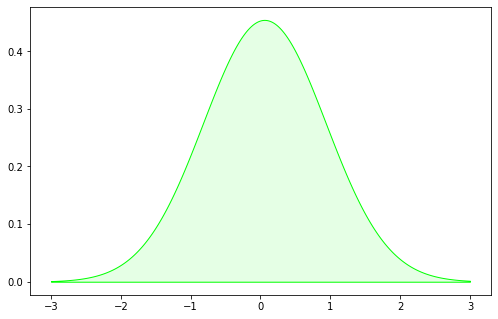

In [12]:
########################################### Evol Simple

evol1G1M1S = stretchevol.Evol1G1M1S()
evol1G1M1S.set_data(df)

print('1G1M1S')

evol1G1M1S.minimize()
evol1G1M1S.show_model_tot()

########################################### Evol Kessler

evol1G1M2S = stretchevol.Evol1G1M2S()
evol1G1M2S.set_data(df)

print('1G1M2S')

evol1G1M2S.minimize()
#evol1G1M2S.show_model_tot()

########################################### Evol Howell

evol2G2M2S = stretchevol.Evol2G2M2S()
evol2G2M2S.set_data(df)

print('2G2M2S')

evol2G2M2S.minimize()
#evol2G2M2S.scatter()

########################################### Evol Howell Fixed

evol2G2M2SF = stretchevol.Evol2G2M2SF()
evol2G2M2SF.set_data(df)

print('2G2M2SF')

evol2G2M2SF.minimize()
#evol2G2M2SF.scatter()

########################################### Evol NR 2S

evol3G2M2S = stretchevol.Evol3G2M2S()
evol3G2M2S.set_data(df)

print('3G2M2S')

evol3G2M2S.minimize()
#evol3G2M2S.scatter()

########################################### Evol NR 2S Fixed

evol3G2M2SF = stretchevol.Evol3G2M2SF()
evol3G2M2SF.set_data(df)

print('3G2M2SF')

evol3G2M2SF.minimize(limit_f = (0,1))
#evol3G2M2SF.scatter()

## Comparison dataframe

In [10]:
modèles = [evol3G2M2S, evol2G2M2S,
           evol1G1M2S, evol2G2M2SF, evol3G2M2SF,
           evol1G1M1S]

d_mod_comp = pd.DataFrame({'Name': [k.__doc__ for k in modèles[:-1]] + ['BBC-modeling'] + [k.__doc__ for k in modèles[-1:]],
                           'Fixed': [k.FIXED for k in modèles[:-1]] + ['True'] + [k.FIXED for k in modèles[-1:]],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles[:-1]] + ['3x5'] + [len(k.FREEPARAMETERS) for k in modèles[-1:]],
                           '$\mathcal{L}$': [round(k.get_logl(),1) for k in modèles[:-1]] + [1083.6 if cons.value else 1468.2] + [round(k.get_logl(),1) for k in modèles[-1:]],
                           'AIC': [round(k.get_aic(),1) for k in modèles[:-1]] + [1113.6 if cons.value else 1498.2] + [round(k.get_aic(),1) for k in modèles[-1:]],
                           '$\Delta$ AIC': [round(evol3G2M2S.get_aic()-k.get_aic(),1) for k in modèles[:-1]] + [-24.1 if cons.value else -31.5] + [round(evol3G2M2S.get_aic()-k.get_aic(),1) for k in modèles[-1:]],
                           'Proba': [get_proba(k) for k in modèles[:-1]] + [5.7e-6 if cons.value else 1.5e-7] + [get_proba(k) for k in modèles[-1:]]
                          })

path = '../../Data/df_comparaison'
if cons.value:
    path += '_cons'
path += '.dat'
d_mod_comp.to_csv(path)

d_mod_comp

,Name,Fixed,Free param,$\mathcal{L}$,AIC,$\Delta$ AIC,Proba
0,Base,False,5,1456.7,1466.7,0.0,1.000000e+00
1,Howell,False,4,1463.3,1471.3,-4.6,1.013335e-01
2,Asymmetric,True,3,1485.2,1491.2,-24.5,4.714564e-06
3,Howell:$f$,True,5,1484.2,1494.2,-27.5,1.048779e-06
4,Base:$f$,True,6,1484.2,1496.2,-29.5,3.858272e-07
5,BBC-modeling,True,3x5,1468.2,1498.2,-31.5,1.500000e-07
6,Gaussian,True,2,1521.8,1525.8,-59.1,1.453479e-13
